In [1]:
from pathlib import Path
from IPython.display import HTML, display
css = Path("../../../css/custom.css").read_text(encoding="utf-8")
display(HTML(f"<style>{css}</style>"))

# Chapter 5 — Decision Trees and Variants
## Lesson 6: Interpretability and Feature Importance in Trees

### What you will learn

By the end of this lesson you will be able to:

- Explain what “interpretability” means for tree models and why it matters in practice (debugging, trust, governance).
- Extract **global explanations** (feature importance, impurity reduction) and understand their limitations.
- Produce **model-agnostic importance** via **permutation importance** and interpret it correctly.
- Generate **local explanations** using decision paths and rule-based reasoning for individual predictions.
- Use **partial dependence** (PDP) and **individual conditional expectation** (ICE) style plots to study marginal effects.
- Understand common pitfalls: leakage, correlated features, high-cardinality bias, instability, and how to mitigate them.

---

### Why trees are considered “interpretable” (and when they are not)

A single decision tree is often treated as interpretable because it represents a **piecewise-constant** function defined by a set of **if–then** rules. Each internal node tests a condition like:

- $x_j \le t$ (numeric split)  
- or a membership test after encoding (categorical splits in practice are usually handled through one-hot/ordinal encodings)

A path from the root to a leaf is a **conjunction** of such rules. For a classifier, a leaf typically stores a class distribution (or counts), and the prediction is the majority class (or the largest probability).

However, interpretability is not binary. It depends on:

- **Tree size** (depth, number of leaves)
- **Feature engineering** (e.g., many one-hot columns can explode rule complexity)
- **Data quality** (leakage makes “explanations” meaningless)
- **Audience** (data scientists vs domain experts)

As a rough heuristic: a shallow tree (depth 2–5) is often human-auditable; deeper trees quickly become cognitively expensive.

---

### Feature importance: what it is (and what it is not)

When people say “feature importance in trees”, they may mean one of several different quantities:

1. **Impurity-based importance** (a.k.a. *mean decrease in impurity*, MDI)  
2. **Permutation importance** (model-agnostic; based on performance drop when a feature is shuffled)  
3. **Drop-column importance** (retrain without a feature; expensive but sometimes more faithful)
4. **Local attribution methods** (e.g., SHAP values) which explain *specific predictions*

These are not interchangeable. They answer different questions.

In this lesson we implement (1) and (2) in detail, show local decision paths, and demonstrate PDP/ICE-style analysis. We also include an optional SHAP section if you want a more advanced local explanation method.

---

### Datasets used in this lesson

To match the structure of your repository, we will load multiple datasets using relative paths such as:

- `../../../Datasets/Classification/iris.csv`
- `../../../Datasets/Classification/diabetes.csv`
- `../../../Datasets/Classification/drug200.csv`
- `../../../Datasets/Regression/house-prices.csv`

We intentionally use **more than one dataset** to show that interpretability behaviors vary across domains, target types (classification vs regression), and feature types (numeric vs categorical).

> Note: If you run this notebook inside the repository at `Tutorials/English/Chapter5/Chapter5_Lesson6.ipynb`, the paths above should resolve correctly.

In [2]:
# Core scientific stack
import numpy as np
import pandas as pd

# Modeling
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree, export_text
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    mean_absolute_error, mean_squared_error, r2_score
)

# Interpretability tools
from sklearn.inspection import permutation_importance, PartialDependenceDisplay

# Plotting (matplotlib only; no seaborn)
import matplotlib.pyplot as plt

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 120)

In [3]:
def read_csv_rel(path):
    # Read a CSV using the repository-relative path convention used in this course.
    return pd.read_csv(path)

def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def pretty_barh(labels, values, title, top_n=20):
    # Simple horizontal bar plot for importances.
    labels = np.array(labels)
    values = np.array(values, dtype=float)
    order = np.argsort(values)[::-1][:top_n]
    labels = labels[order][::-1]
    values = values[order][::-1]

    plt.figure(figsize=(9, max(3, 0.35 * len(labels))))
    plt.barh(labels, values)
    plt.title(title)
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()

def get_ohe_feature_names(ohe, input_features):
    # Compatibility helper for different scikit-learn versions.
    if hasattr(ohe, "get_feature_names_out"):
        return ohe.get_feature_names_out(input_features)
    # Older versions:
    return ohe.get_feature_names(input_features)

def safe_accuracy(y_true, y_pred):
    # A tiny helper to keep code clean when experimenting.
    return float(accuracy_score(y_true, y_pred))

## 1) Impurity-based importance (MDI) on a classic numeric dataset (Iris)

### Quick theory

For classification trees, common node impurity measures are:

- **Gini impurity:** $G = 1 - \sum_k p_k^2$
- **Entropy:** $H = -\sum_k p_k \log(p_k)$

A split is considered “good” if it **reduces impurity**. If a node with $n$ samples is split into left/right children with $n_L, n_R$, then an impurity decrease looks like:

$$\Delta = I(\text{parent}) - \frac{n_L}{n} I(\text{left}) - \frac{n_R}{n} I(\text{right})$$

**Impurity-based importance** for feature $j$ roughly sums $\Delta$ over all nodes where feature $j$ is used, often normalized so importances sum to 1.

**Important caveat:** MDI is **not** “causal importance”. It is sensitive to:
- correlated features (importance can be “stolen”)
- different scales / number of split points (continuous features can get more chances to split)
- preprocessing and encodings

We start with Iris because it is small, fully numeric, and easy to visualize.

In [4]:
# Load Iris (classification) using the repository-relative path
iris_path = "../../../Datasets/Classification/iris.csv"
df_iris = read_csv_rel(iris_path)
df_iris.head()

,sepal_length,sepal_width,petal_length,petal_width,classification
0,5.4,3.7,1.5,0.2,Iris-setosa
1,4.8,3.4,1.6,0.2,Iris-setosa
2,4.8,3.0,1.4,0.1,Iris-setosa
3,4.3,3.0,1.1,0.1,Iris-setosa
4,5.8,4.0,1.2,0.2,Iris-setosa


In [5]:
# Separate features/target
target_col = "classification"
X = df_iris.drop(columns=[target_col])
y = df_iris[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y
)

# A deliberately small tree for interpretability
clf = DecisionTreeClassifier(
    max_depth=3,
    min_samples_leaf=2,
    random_state=RANDOM_STATE
)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8947368421052632

Classification report:
                  precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        12
Iris-versicolor       0.80      0.92      0.86        13
 Iris-virginica       0.91      0.77      0.83        13

       accuracy                           0.89        38
      macro avg       0.90      0.90      0.90        38
   weighted avg       0.90      0.89      0.89        38



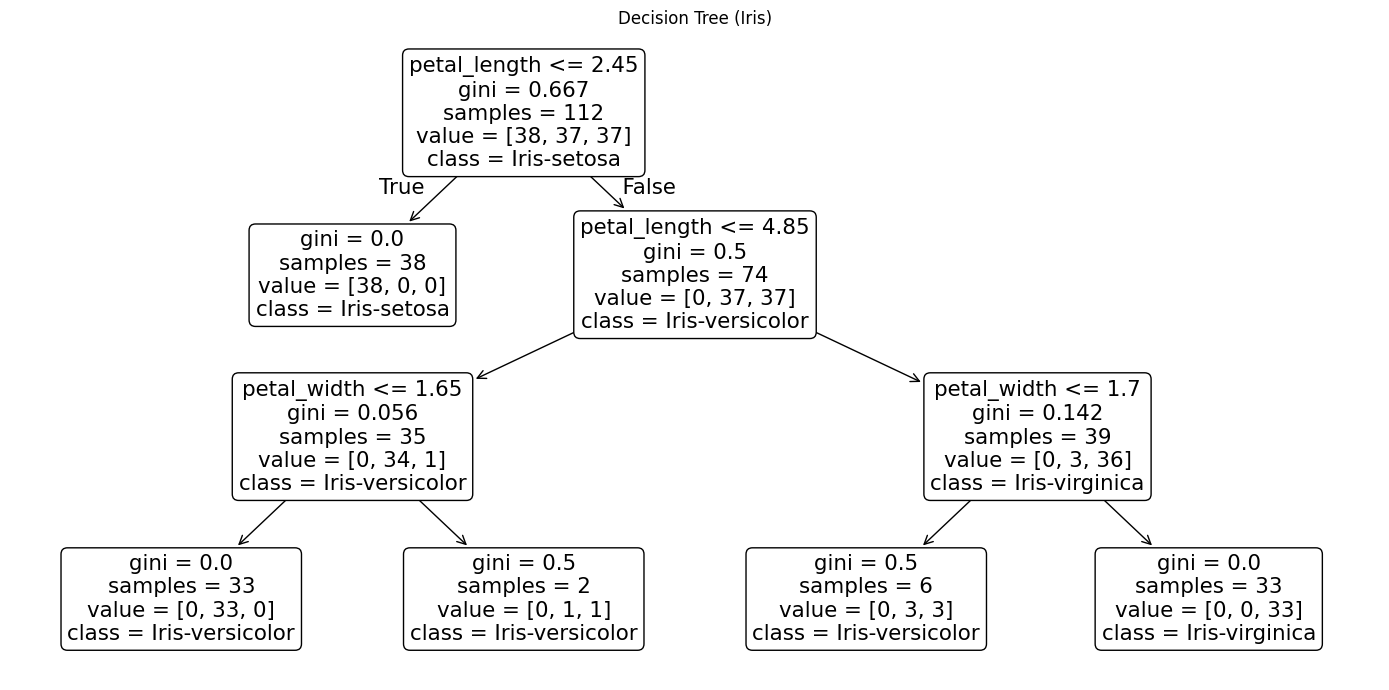

|--- petal_length <= 2.45
|   |--- class: Iris-setosa
|--- petal_length >  2.45
|   |--- petal_length <= 4.85
|   |   |--- petal_width <= 1.65
|   |   |   |--- class: Iris-versicolor
|   |   |--- petal_width >  1.65
|   |   |   |--- class: Iris-versicolor
|   |--- petal_length >  4.85
|   |   |--- petal_width <= 1.70
|   |   |   |--- class: Iris-versicolor
|   |   |--- petal_width >  1.70
|   |   |   |--- class: Iris-virginica



In [6]:
# Visualize the trained tree
plt.figure(figsize=(14, 7))
plot_tree(
    clf,
    feature_names=X.columns,
    class_names=sorted(y.unique()),
    filled=False,
    rounded=True,
    impurity=True
)
plt.title("Decision Tree (Iris)")
plt.tight_layout()
plt.show()

# Text rules (compact)
print(export_text(clf, feature_names=list(X.columns)))

### MDI feature importance on Iris

We can inspect `feature_importances_` from scikit-learn trees. This is the MDI (impurity-based) importance.

Interpretation (global): *“Over the whole training set, how much did this feature contribute to impurity reductions in the fitted tree?”*

In [7]:
mdi = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)
mdi

petal_length    0.950732
petal_width     0.049268
sepal_width     0.000000
sepal_length    0.000000
dtype: float64

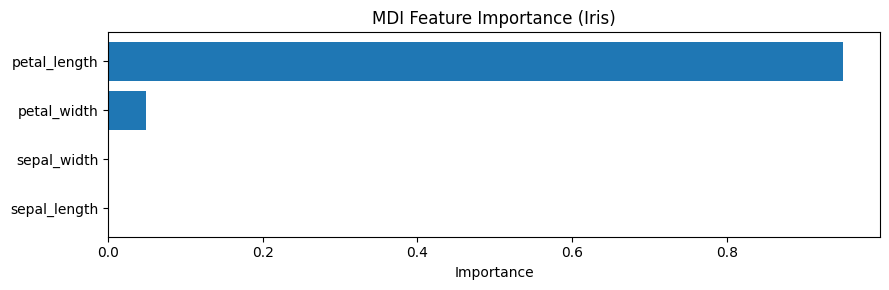

In [8]:
pretty_barh(mdi.index, mdi.values, title="MDI Feature Importance (Iris)")

### Pitfalls of impurity-based importance

Even though MDI is fast and built-in, you must treat it as a *model diagnostic*, not a truth oracle.

Common failure modes:

- **Correlation / redundancy:** if two features carry the same information, the tree may choose one early and the other gets low importance. Another tree (or another random seed) can flip this.
- **High-cardinality bias:** continuous variables or categorical variables with many levels can create many candidate splits, so they may get inflated MDI importance.
- **Overfitting:** deep trees can create spurious splits that look “important” but do not generalize.
- **Leakage:** if a feature encodes the label (directly or indirectly), it will dominate importance but the model is not learning what you think it is.

A safer alternative for “importance” is to measure **performance drop** when the feature is destroyed — which leads to permutation importance.

## 2) Permutation importance (model-agnostic)

### Definition

Permutation importance for feature $j$ measures the expected increase in loss when we randomly shuffle that feature’s values (breaking its association with the target) while keeping everything else fixed.

If $L$ is a loss (or negative score), then a generic definition is:

$$I_j = \mathbb{E}[L(f(X^{\pi_j}), y) - L(f(X), y)]$$

Where $X^{\pi_j}$ is $X$ but with column $j$ permuted.

Key properties:
- Uses a **held-out** set (validation/test) to measure generalization.
- Works for **any model** (not only trees).
- Still has pitfalls: correlated features can reduce measured importance (shuffling one correlated feature may not hurt much because the other still carries the signal).

We compute permutation importance on the Iris test set.

In [9]:
perm = permutation_importance(
    clf, X_test, y_test,
    n_repeats=20,
    random_state=RANDOM_STATE,
    scoring="accuracy"
)

pi = pd.Series(perm.importances_mean, index=X.columns).sort_values(ascending=False)
pi

petal_length    0.482895
petal_width     0.150000
sepal_width     0.000000
sepal_length    0.000000
dtype: float64

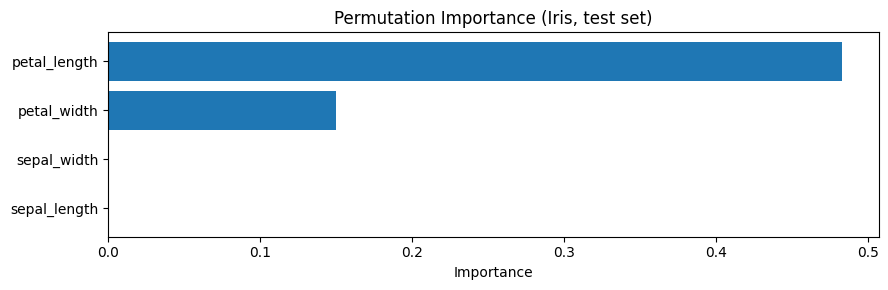

In [10]:
pretty_barh(pi.index, pi.values, title="Permutation Importance (Iris, test set)")

## 2.1) Correlation pitfall demo: “importance stealing”

Permutation importance can *understate* the importance of correlated features because shuffling one feature may not hurt much if another correlated feature still contains the same information.

Impurity importance can also behave strangely: the tree may choose one correlated feature early, giving it most of the credit.

To demonstrate, we will create a new feature that is almost a duplicate of an existing one (tiny noise added) and observe how importance splits between them.

MDI (with correlated duplicate):
petal_width         0.582248
petal_length        0.417752
sepal_length        0.000000
sepal_width         0.000000
petal_length_dup    0.000000
dtype: float64 

Permutation importance (with correlated duplicate):
petal_width         0.494737
petal_length        0.144211
sepal_length        0.000000
sepal_width         0.000000
petal_length_dup    0.000000
dtype: float64


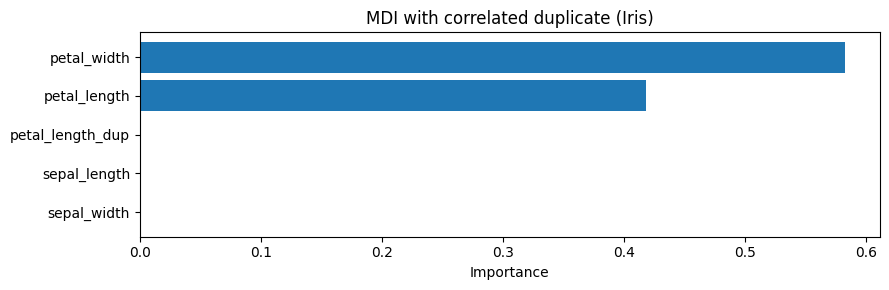

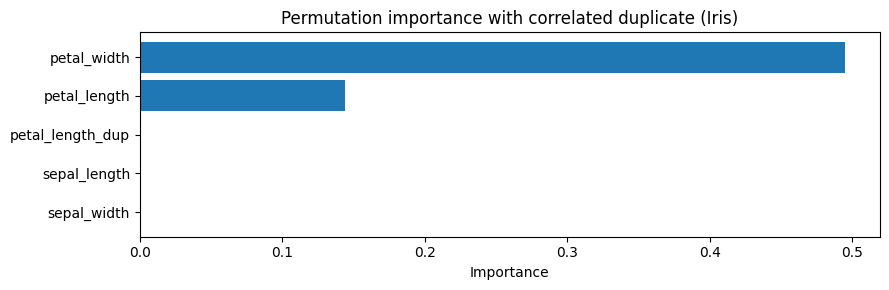

In [11]:
X_corr = X.copy()
X_corr["petal_length_dup"] = X_corr["petal_length"] + np.random.normal(scale=0.01, size=len(X_corr))

Xc_train, Xc_test, yc_train, yc_test = train_test_split(
    X_corr, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y
)

clf_corr = DecisionTreeClassifier(max_depth=3, min_samples_leaf=2, random_state=RANDOM_STATE)
clf_corr.fit(Xc_train, yc_train)

# MDI
mdi_corr = pd.Series(clf_corr.feature_importances_, index=X_corr.columns).sort_values(ascending=False)
print("MDI (with correlated duplicate):")
print(mdi_corr, "\n")

# Permutation
perm_corr = permutation_importance(
    clf_corr, Xc_test, yc_test,
    n_repeats=25, random_state=RANDOM_STATE, scoring="accuracy"
)
pi_corr = pd.Series(perm_corr.importances_mean, index=X_corr.columns).sort_values(ascending=False)

print("Permutation importance (with correlated duplicate):")
print(pi_corr)

pretty_barh(mdi_corr.index, mdi_corr.values, title="MDI with correlated duplicate (Iris)")
pretty_barh(pi_corr.index, pi_corr.values, title="Permutation importance with correlated duplicate (Iris)")

## 3) Local interpretability: decision paths and “why this prediction?”

Global feature importances summarize behavior across many samples. But in practice you often need **local explanations**, such as:

- “Why did this particular sample get class *Iris-versicolor*?”
- “Which conditions pushed it to that leaf?”

For a decision tree, the explanation can be expressed as the **set of rules** on the root-to-leaf path.

We’ll pick a single test sample and extract its path.

In [12]:
# Pick one sample from the test set
i = 0
x0 = X_test.iloc[[i]]
y0 = y_test.iloc[i]
pred0 = clf.predict(x0)[0]

print("True label :", y0)
print("Pred label :", pred0)
print("\nSample values:\n", x0)

# Decision path: which nodes are visited?
node_indicator = clf.decision_path(x0)
leaf_id = clf.apply(x0)[0]

print("\nLeaf node id:", leaf_id)
print("Number of nodes visited:", node_indicator.indices.shape[0])

True label : Iris-setosa
Pred label : Iris-setosa

Sample values:
     sepal_length  sepal_width  petal_length  petal_width
42           4.4          3.2           1.3          0.2

Leaf node id: 1
Number of nodes visited: 2


In [13]:
# Convert the visited nodes into readable rules
tree_ = clf.tree_
feature = tree_.feature
threshold = tree_.threshold
feature_names = X.columns.to_numpy()

rules = []
for node_id in node_indicator.indices:
    if node_id == leaf_id:
        continue
    f_id = feature[node_id]
    thr = threshold[node_id]
    f_name = feature_names[f_id]
    
    # Determine if sample goes to left or right child
    if x0.iloc[0, f_id] <= thr:
        rule = f"{f_name} <= {thr:.3f}"
    else:
        rule = f"{f_name} >  {thr:.3f}"
    rules.append(rule)

print("Rules on the path:")
for r in rules:
    print(" -", r)

# Optional: show class distribution at the leaf
leaf_value = tree_.value[leaf_id][0]
leaf_probs = leaf_value / leaf_value.sum()
print("\nLeaf class counts:", leaf_value)
print("Leaf class probabilities:", dict(zip(clf.classes_, leaf_probs.round(3))))

Rules on the path:
 - petal_length <= 2.450

Leaf class counts: [1. 0. 0.]
Leaf class probabilities: {'Iris-setosa': np.float64(1.0), 'Iris-versicolor': np.float64(0.0), 'Iris-virginica': np.float64(0.0)}


## 4) Partial dependence (PDP) and ICE-style intuition

Even if a tree is “rule-based”, it can still be useful to study **marginal effects**:

- How does the predicted probability change as we vary one feature while averaging out others?

A **partial dependence plot** (PDP) for feature $x_j$ is conceptually:

$$\text{PDP}(x_j) = \mathbb{E}_{X_{-j}}[f(x_j, X_{-j})]$$

This is an average, so PDP can hide heterogeneity. Many libraries also support ICE (individual conditional expectation), which plots curves per-sample. In scikit-learn we can at least visualize partial dependence; for ICE you can approximate by plotting PDP with `kind="individual"` in newer versions (if available).

We’ll compute PDP for the two most important Iris features (by permutation importance).

In [14]:
top2 = list(pi.index[:2])
top2

['petal_length', 'petal_width']

<Figure size 900x400 with 0 Axes>

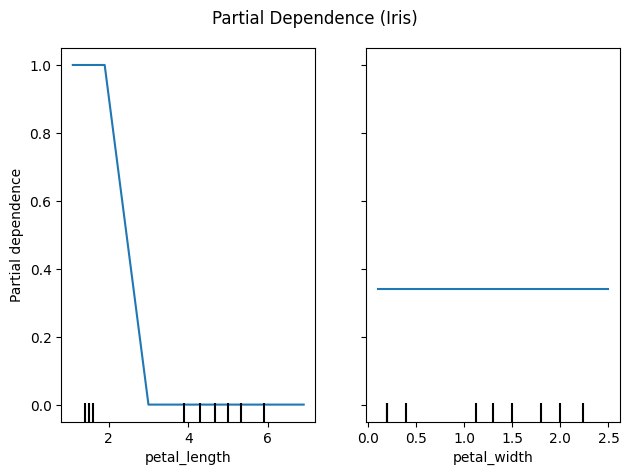

In [15]:
plt.figure(figsize=(9, 4))

# For multi-class classification, scikit-learn requires specifying which class to plot.
# Pick a class label from clf.classes_ (change the index if you want a different class).
pdp_target = None
if hasattr(clf, "classes_") and len(getattr(clf, "classes_", [])) > 2:
    pdp_target = clf.classes_[0]  # e.g., clf.classes_[1] or clf.classes_[2]

PartialDependenceDisplay.from_estimator(
    clf,
    X_train,
    features=top2,
    target=pdp_target,
    kind="average"  # try "individual" if your sklearn supports it
)
plt.suptitle("Partial Dependence (Iris)")
plt.tight_layout()
plt.show()

## 5) Another numeric classification dataset: Diabetes

To avoid overfitting our intuition to a single dataset, we also use `diabetes.csv` (binary classification with a mix of medical predictors).

Goals in this section:

- Train a small tree (still interpretable)
- Compare MDI vs permutation importance on a held-out test set
- Discuss interpretability differences relative to Iris (more features, potentially noisier signal)

We will *not* over-engineer preprocessing here because the dataset is numeric in the provided format.

In [16]:
diab_path = "../../../Datasets/Classification/diabetes.csv"
df_diab = read_csv_rel(diab_path)
df_diab.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,classification
0,6,148,72,35,0,33.6,0.627,50,Diabetic
1,1,85,66,29,0,26.6,0.351,31,Non-Diabetic
2,8,183,64,0,0,23.3,0.672,32,Diabetic
3,1,89,66,23,94,28.1,0.167,21,Non-Diabetic
4,0,137,40,35,168,43.1,2.288,33,Diabetic


In [17]:
target_col = "classification"
Xd2 = df_diab.drop(columns=[target_col])
yd2 = df_diab[target_col]

Xd2_train, Xd2_test, yd2_train, yd2_test = train_test_split(
    Xd2, yd2, test_size=0.25, random_state=RANDOM_STATE, stratify=yd2
)

clf_d = DecisionTreeClassifier(
    max_depth=4,
    min_samples_leaf=15,
    random_state=RANDOM_STATE
)
clf_d.fit(Xd2_train, yd2_train)

pred_d = clf_d.predict(Xd2_test)
print("Accuracy:", accuracy_score(yd2_test, pred_d))
print("\nClassification report:\n", classification_report(yd2_test, pred_d))

Accuracy: 0.75

Classification report:
               precision    recall  f1-score   support

    Diabetic       0.67      0.55      0.61        67
Non-Diabetic       0.78      0.86      0.82       125

    accuracy                           0.75       192
   macro avg       0.73      0.70      0.71       192
weighted avg       0.74      0.75      0.74       192



Top MDI features:
Glucose                     0.554097
Age                         0.186199
BMI                         0.110291
DiabetesPedigreeFunction    0.093670
Pregnancies                 0.055743
BloodPressure               0.000000
SkinThickness               0.000000
Insulin                     0.000000
dtype: float64 

Top permutation importance features:
Glucose                     0.111719
BMI                         0.041146
DiabetesPedigreeFunction    0.040365
Age                         0.039323
BloodPressure               0.000000
SkinThickness               0.000000
Insulin                     0.000000
Pregnancies                -0.008333
dtype: float64


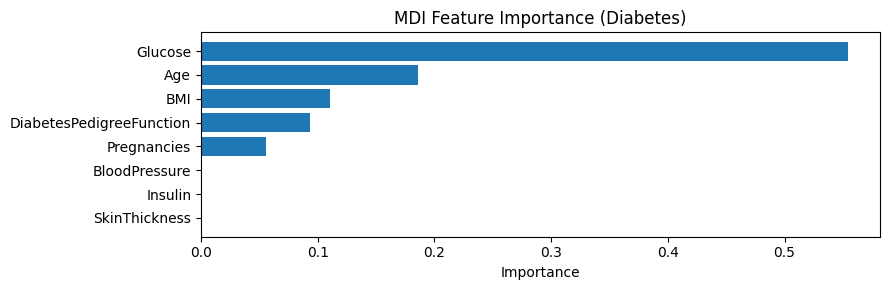

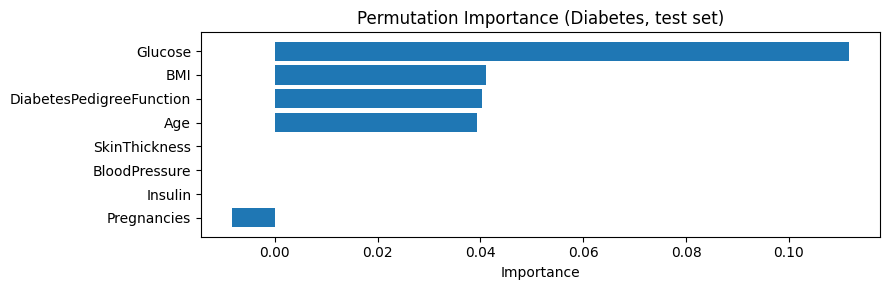

In [18]:
mdi_d = pd.Series(clf_d.feature_importances_, index=Xd2.columns).sort_values(ascending=False)

perm_d = permutation_importance(
    clf_d, Xd2_test, yd2_test,
    n_repeats=20, random_state=RANDOM_STATE, scoring="accuracy"
)
pi_d = pd.Series(perm_d.importances_mean, index=Xd2.columns).sort_values(ascending=False)

print("Top MDI features:")
print(mdi_d.head(10), "\n")

print("Top permutation importance features:")
print(pi_d.head(10))

pretty_barh(mdi_d.index, mdi_d.values, title="MDI Feature Importance (Diabetes)", top_n=12)
pretty_barh(pi_d.index, pi_d.values, title="Permutation Importance (Diabetes, test set)", top_n=12)

### 5.1) Drop-column importance (small, illustrative)

Drop-column importance retrains a model without a feature and measures the performance change.

Pros:
- Can reflect the effect of excluding a feature more faithfully than shuffling.

Cons:
- Much more expensive (retraining per feature)
- Still affected by correlation (dropping one correlated feature may not hurt much)

Below we do a tiny version: we test the top 5 permutation-important features by dropping each one and retraining the same tree configuration.

In [19]:
base_score = safe_accuracy(yd2_test, clf_d.predict(Xd2_test))
print("Baseline accuracy:", base_score)

top5 = list(pi_d.index[:5])
results = []

for col in top5:
    X_train_dc = Xd2_train.drop(columns=[col])
    X_test_dc  = Xd2_test.drop(columns=[col])

    m = DecisionTreeClassifier(max_depth=4, min_samples_leaf=15, random_state=RANDOM_STATE)
    m.fit(X_train_dc, yd2_train)
    score = safe_accuracy(yd2_test, m.predict(X_test_dc))
    results.append((col, base_score - score))

dropcol = pd.DataFrame(results, columns=["dropped_feature", "accuracy_drop"]).sort_values("accuracy_drop", ascending=False)
dropcol

Baseline accuracy: 0.75


,dropped_feature,accuracy_drop
0,Glucose,0.041667
1,BMI,0.036458
2,DiabetesPedigreeFunction,0.020833
3,Age,0.000000
4,BloodPressure,0.000000


## 6) Interpreting ensembles: when the model is not a single tree

In practice, you will often use **Random Forests** because they generalize better than a single tree.

Tradeoff:
- Single tree: easy local rule explanations, but can overfit / high variance
- Random forest: better accuracy and stability, but harder to explain as a compact set of rules

You can still use:
- Permutation importance (works for any model)
- PDP (approximate marginal effects)
- Local methods like SHAP (often used with tree ensembles)

We’ll train a small RandomForest on Iris and compare its permutation importance to the single tree.

RandomForest accuracy: 0.8947368421052632

Permutation importance (RF, Iris):
petal_length    0.206579
petal_width     0.019737
sepal_width    -0.025000
sepal_length   -0.026316
dtype: float64


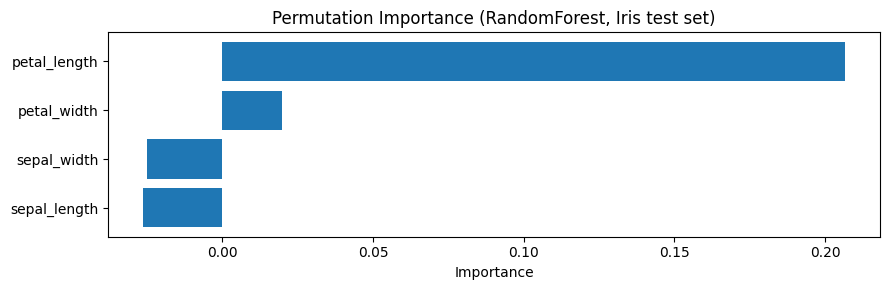

In [20]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_leaf=1,
    random_state=RANDOM_STATE
)
rf.fit(X_train, y_train)

pred_rf = rf.predict(X_test)
print("RandomForest accuracy:", accuracy_score(y_test, pred_rf))

perm_rf = permutation_importance(
    rf, X_test, y_test,
    n_repeats=20, random_state=RANDOM_STATE, scoring="accuracy"
)
pi_rf = pd.Series(perm_rf.importances_mean, index=X.columns).sort_values(ascending=False)

print("\nPermutation importance (RF, Iris):")
print(pi_rf)

pretty_barh(pi_rf.index, pi_rf.values, title="Permutation Importance (RandomForest, Iris test set)")

## 7) Regression example: feature importance can change with target type

Trees are used for both classification and regression. For regression trees, impurity is often based on variance reduction (MSE-like).

We’ll use `house-prices.csv` (mixed numeric + categorical) and build a pipeline:

- Impute missing values
- One-hot encode categorical features
- Fit a shallow `DecisionTreeRegressor`
- Compare impurity importance (on transformed features) vs permutation importance (on original feature blocks)

Why this matters:
- One-hot encoding creates many columns, so “feature importance” becomes harder to interpret.
- You may want to **group** importances back to the original features.

In [21]:
house_path = "../../../Datasets/Regression/house-prices.csv"
df_house = read_csv_rel(house_path)
df_house.head()

,Home,Price,SqFt,Bedrooms,Bathrooms,Offers,Brick,Neighborhood
0,1,114300,1790,2,2,2,No,East
1,2,114200,2030,4,2,3,No,East
2,3,114800,1740,3,2,1,No,East
3,4,94700,1980,3,2,3,No,East
4,5,119800,2130,3,3,3,No,East


In [22]:
# Target and features
target = "Price"
Xh = df_house.drop(columns=[target])
yh = df_house[target]

# Identify numeric/categorical columns
num_cols = Xh.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in Xh.columns if c not in num_cols]

print("Numeric columns    :", num_cols)
print("Categorical columns:", cat_cols)

# Preprocessing
numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, num_cols),
        ("cat", categorical_pipe, cat_cols)
    ],
    remainder="drop"
)

reg = DecisionTreeRegressor(
    max_depth=4,
    min_samples_leaf=5,
    random_state=RANDOM_STATE
)

pipe_reg = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", reg)
])

Xh_train, Xh_test, yh_train, yh_test = train_test_split(
    Xh, yh, test_size=0.25, random_state=RANDOM_STATE
)

pipe_reg.fit(Xh_train, yh_train)
pred = pipe_reg.predict(Xh_test)

print("MAE :", mean_absolute_error(yh_test, pred))
print("RMSE:", rmse(yh_test, pred))
print("R^2 :", r2_score(yh_test, pred))

Numeric columns    : ['Home', 'SqFt', 'Bedrooms', 'Bathrooms', 'Offers']
Categorical columns: ['Brick', 'Neighborhood']
MAE : 10239.341179653678
RMSE: 14728.700034217107
R^2 : 0.6461196795703062


### MDI importance in a pipeline (transformed feature space)

When we use preprocessing, the tree is trained on transformed columns. For one-hot encoding, the model sees columns like `Neighborhood_East`, `Neighborhood_North`, etc.

To interpret MDI importance, we can extract the transformed feature names and plot the top ones.

In [23]:
# Extract feature names after preprocessing
pre = pipe_reg.named_steps["preprocess"]
ohe = pre.named_transformers_["cat"].named_steps["ohe"]

ohe_names = get_ohe_feature_names(ohe, cat_cols)
feature_names_transformed = np.concatenate([np.array(num_cols), np.array(ohe_names)])

mdi_reg = pipe_reg.named_steps["model"].feature_importances_
mdi_reg_s = pd.Series(mdi_reg, index=feature_names_transformed).sort_values(ascending=False)
mdi_reg_s.head(15)

Neighborhood_West     0.599048
SqFt                  0.180626
Brick_No              0.093811
Offers                0.048503
Bedrooms              0.038654
Neighborhood_North    0.026220
Brick_Yes             0.013138
Home                  0.000000
Bathrooms             0.000000
Neighborhood_East     0.000000
dtype: float64

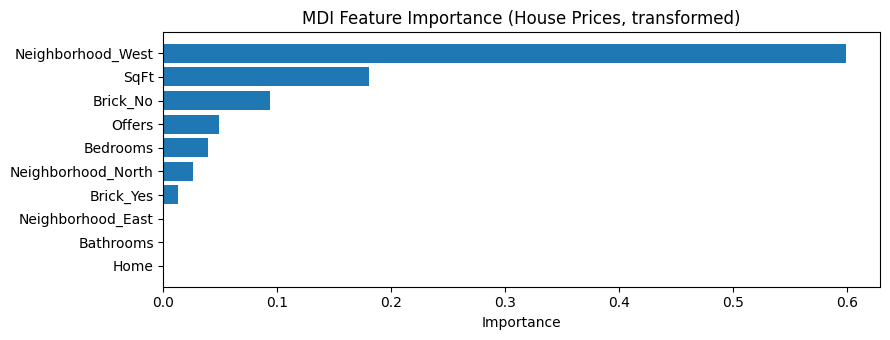

In [24]:
pretty_barh(mdi_reg_s.index, mdi_reg_s.values, title="MDI Feature Importance (House Prices, transformed)", top_n=15)

### Permutation importance on the test set (pipeline-aware)

Permutation importance can be computed directly on the pipeline. This is convenient: we shuffle columns in the **original** `Xh_test` DataFrame, and the pipeline handles preprocessing consistently.

This gives importances at the **original feature** level (before one-hot expansion), which is often what you want for communication.

In [25]:
perm_reg = permutation_importance(
    pipe_reg, Xh_test, yh_test,
    n_repeats=20,
    random_state=RANDOM_STATE,
    scoring="neg_mean_absolute_error"
)

pi_reg = pd.Series(perm_reg.importances_mean, index=Xh.columns).sort_values(ascending=False)
pi_reg

Neighborhood    10357.210949
SqFt             5731.574112
Brick            3177.752976
Offers           1554.519548
Home                0.000000
Bathrooms           0.000000
Bedrooms         -295.156250
dtype: float64

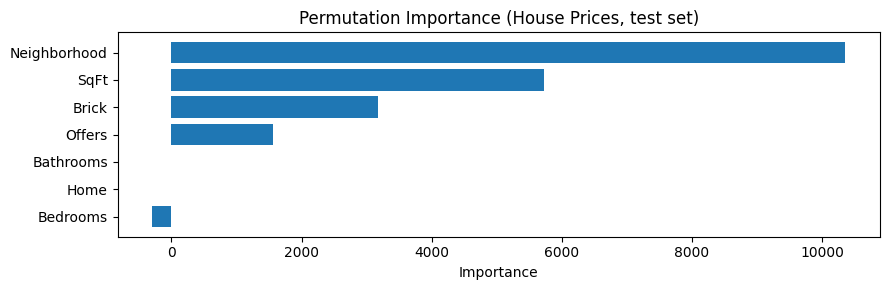

In [26]:
pretty_barh(pi_reg.index, pi_reg.values, title="Permutation Importance (House Prices, test set)")

## 8) Categorical-heavy classification: importance with one-hot encoding (Drug200)

Many real-world structured datasets have categorical predictors. Trees can split on categories, but in scikit-learn we typically represent them numerically (often with one-hot encoding).

We will:
- Load `drug200.csv`
- Build a preprocessing + `DecisionTreeClassifier` pipeline
- Compute permutation importance on the test set
- **Group** one-hot importances back to the original categorical feature (optional)

This demonstrates a practical point: raw “importance of one-hot columns” is rarely what stakeholders want.

In [27]:
drug_path = "../../../Datasets/Classification/drug200.csv"
df_drug = read_csv_rel(drug_path)
df_drug.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY


In [28]:
target = "Drug"
Xd = df_drug.drop(columns=[target])
yd = df_drug[target]

num_cols = Xd.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in Xd.columns if c not in num_cols]

numeric_pipe = Pipeline(steps=[("imputer", SimpleImputer(strategy="median"))])
categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocess = ColumnTransformer(
    transformers=[("num", numeric_pipe, num_cols), ("cat", categorical_pipe, cat_cols)]
)

clf_cat = DecisionTreeClassifier(
    max_depth=5,
    min_samples_leaf=10,
    random_state=RANDOM_STATE
)

pipe_clf = Pipeline(steps=[("preprocess", preprocess), ("model", clf_cat)])

Xd_train, Xd_test, yd_train, yd_test = train_test_split(
    Xd, yd, test_size=0.25, random_state=RANDOM_STATE, stratify=yd
)

pipe_clf.fit(Xd_train, yd_train)
yd_pred = pipe_clf.predict(Xd_test)

print("Accuracy:", accuracy_score(yd_test, yd_pred))
print("\nClassification report:\n", classification_report(yd_test, yd_pred))

Accuracy: 0.98

Classification report:
               precision    recall  f1-score   support

       DrugY       0.96      1.00      0.98        23
       drugA       1.00      1.00      1.00         6
       drugB       1.00      1.00      1.00         4
       drugC       1.00      1.00      1.00         4
       drugX       1.00      0.92      0.96        13

    accuracy                           0.98        50
   macro avg       0.99      0.98      0.99        50
weighted avg       0.98      0.98      0.98        50



In [29]:
perm_drug = permutation_importance(
    pipe_clf, Xd_test, yd_test,
    n_repeats=25,
    random_state=RANDOM_STATE,
    scoring="accuracy"
)

pi_drug = pd.Series(perm_drug.importances_mean, index=Xd.columns).sort_values(ascending=False)
pi_drug

Na_to_K        0.4880
BP             0.3024
Age            0.0936
Cholesterol    0.0704
Sex            0.0000
dtype: float64

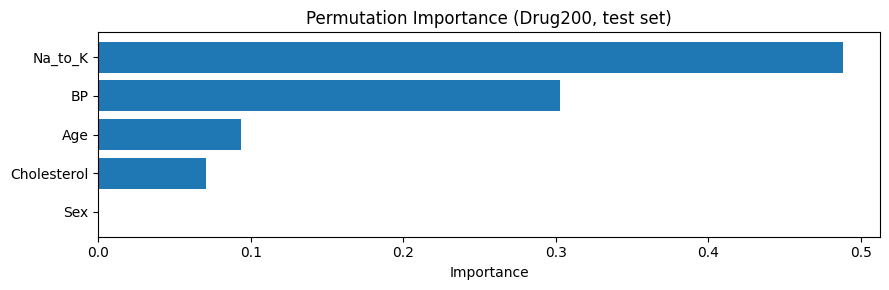

In [30]:
pretty_barh(pi_drug.index, pi_drug.values, title="Permutation Importance (Drug200, test set)")

## 9) Stability: “importance” is a random variable (bootstrap view)

A common mistake is to treat one run of feature importance as definitive. In reality, importance is **estimated** from finite data and depends on:

- the sampled train/test split
- the fitted tree structure (which can change a lot with small perturbations)
- random seeds (especially in ensembles, but even in split procedures)

A practical way to quantify uncertainty is to bootstrap the dataset or repeat train/test splits and compute importances each time, then visualize the distribution.

Below we do a lightweight bootstrap for permutation importance on Iris to show how variable the estimates can be.

In [31]:
def bootstrap_perm_importance(X, y, scoring, n_boot=50, test_size=0.25, n_repeats=10):
    importances = []
    rng = np.random.RandomState(RANDOM_STATE)
    for b in range(n_boot):
        # Bootstrap sample indices
        idx = rng.choice(len(X), size=len(X), replace=True)
        Xb = X.iloc[idx].reset_index(drop=True)
        yb = y.iloc[idx].reset_index(drop=True)

        X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(
            Xb, yb, test_size=test_size, random_state=rng.randint(0, 10_000), stratify=yb
        )

        est = DecisionTreeClassifier(max_depth=3, min_samples_leaf=2, random_state=rng.randint(0, 10_000))
        est.fit(X_train_b, y_train_b)

        perm = permutation_importance(
            est, X_test_b, y_test_b,
            n_repeats=n_repeats,
            random_state=rng.randint(0, 10_000),
            scoring=scoring
        )
        importances.append(perm.importances_mean)

    return np.vstack(importances)

boot = bootstrap_perm_importance(X, y, scoring="accuracy", n_boot=60, n_repeats=10)
boot.shape

(60, 4)

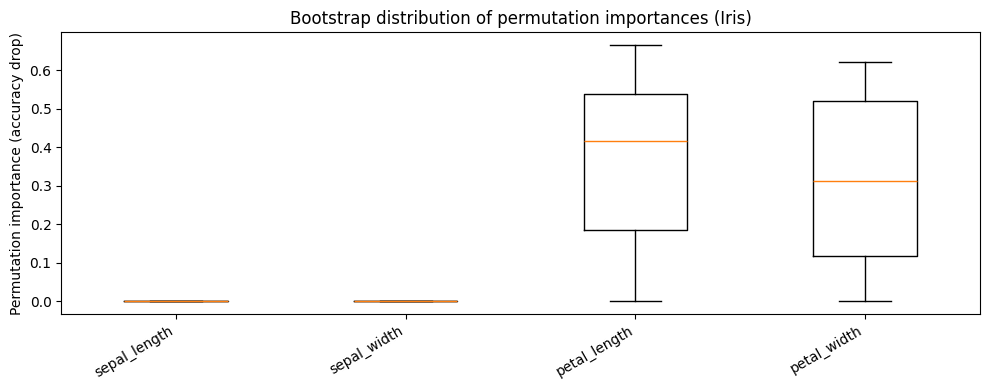

,mean,std
petal_length,0.361754,0.207717
petal_width,0.308596,0.210105
sepal_length,0.005439,0.026607
sepal_width,0.000000,0.000000


In [32]:
# Visualize distribution as a simple boxplot (matplotlib)
plt.figure(figsize=(10, 4))
plt.boxplot(boot, tick_labels=list(X.columns), vert=True, showfliers=False)
plt.title("Bootstrap distribution of permutation importances (Iris)")
plt.ylabel("Permutation importance (accuracy drop)")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

# Also show mean +/- std numerically
boot_mean = boot.mean(axis=0)
boot_std = boot.std(axis=0)
summary = pd.DataFrame({"mean": boot_mean, "std": boot_std}, index=X.columns).sort_values("mean", ascending=False)
summary

## 10) Optional: SHAP for tree models (local attributions)

SHAP (SHapley Additive exPlanations) assigns each feature a contribution value for a specific prediction, grounded in cooperative game theory (Shapley values). For tree models, `shap` provides efficient algorithms.

Why “optional”? Because `shap` may not be installed in your runtime, and in some environments installing packages is restricted.

If available, the code below will:
- Fit a tree model
- Compute SHAP values for a small batch
- Produce a summary plot (global view) and a local explanation

If it fails, you can skip this section without losing continuity.

In [33]:
try:
    import shap
    SHAP_AVAILABLE = True
except Exception as e:
    SHAP_AVAILABLE = False
    print("SHAP is not installed. This section is optional and can be skipped. Details:", repr(e))

if SHAP_AVAILABLE:
    # Use the Iris classifier we already trained (clf) for a SHAP demo
    # shap expects numeric arrays; for multiclass it returns a list
    explainer = shap.TreeExplainer(clf)
    X_sample = X_test.iloc[:40]
    shap_values = explainer.shap_values(X_sample)

    # Summary plot (may open a figure)
    shap.summary_plot(shap_values, X_sample, show=True)

    # Local explanation for a single instance (class-conditional in multiclass)
    idx = 0
    shap.force_plot(explainer.expected_value[0], shap_values[0][idx, :], X_sample.iloc[idx, :], matplotlib=True)

SHAP is not installed. This section is optional and can be skipped. Details: ModuleNotFoundError("No module named 'shap'")


## 11) Best-practice checklist for interpretability in trees

Use this checklist when you communicate or operationalize “feature importance”:

1. **Define the question**
   - Global vs local?
   - Prediction explanation vs causal mechanism?
2. **Use a valid evaluation protocol**
   - Compute permutation importance on a held-out set or via cross-validation.
3. **Control for leakage**
   - Sanity-check suspicious features (post-outcome variables, IDs, timestamps encoding target).
4. **Handle correlated features carefully**
   - Consider grouped importance, conditional permutation, or domain-driven grouping.
5. **Quantify uncertainty**
   - Repeat splits, bootstrap, or cross-validated importance.
6. **Keep the model interpretable by design**
   - Limit depth, prune, or build a small surrogate tree for explanation.
7. **Document assumptions**
   - Data generation assumptions, preprocessing steps, and what “importance” actually measures.

---

## 12) Exercises (with suggested solutions)

### Exercise 1 — Compare split criteria and importance stability
Train two Iris trees of depth 3:
- one with `criterion="gini"`
- one with `criterion="entropy"`

Compute permutation importance on the same test set and compare. Are rankings stable?

### Exercise 2 — Decision-path explanation report
Pick 5 samples from the Iris test set and print a compact report:
- true label
- predicted label
- path rules
- leaf probabilities

### Exercise 3 — Grouped importance for one-hot encoding
On the Drug200 dataset, compute permutation importance at the **original feature** level (already done). Now compute MDI at the **one-hot feature** level and then sum importances back to the original categorical feature names.

### Exercise 4 — Diabetes: compare permutation vs drop-column
Repeat the drop-column test for 10 features (top 10 by permutation importance). Do you see any differences?

### Exercise 5 — Ensemble surrogate
Train a random forest on Iris. Then train a shallow tree to predict the random forest’s predicted class labels. How accurate is the surrogate tree? How interpretable is it?

Below are reference solutions to get you started. You can modify them and experiment.

In [34]:
# --- Exercise 1 solution sketch: gini vs entropy on Iris ---
clf_gini = DecisionTreeClassifier(max_depth=3, min_samples_leaf=2, criterion="gini", random_state=RANDOM_STATE)
clf_ent  = DecisionTreeClassifier(max_depth=3, min_samples_leaf=2, criterion="entropy", random_state=RANDOM_STATE)

clf_gini.fit(X_train, y_train)
clf_ent.fit(X_train, y_train)

perm_g = permutation_importance(clf_gini, X_test, y_test, n_repeats=30, random_state=RANDOM_STATE, scoring="accuracy")
perm_e = permutation_importance(clf_ent,  X_test, y_test, n_repeats=30, random_state=RANDOM_STATE, scoring="accuracy")

pi_g = pd.Series(perm_g.importances_mean, index=X.columns).sort_values(ascending=False)
pi_e = pd.Series(perm_e.importances_mean, index=X.columns).sort_values(ascending=False)

print("Permutation importance ranking (gini):")
print(pi_g, "\n")
print("Permutation importance ranking (entropy):")
print(pi_e)

Permutation importance ranking (gini):
petal_length    0.478947
petal_width     0.151754
sepal_width     0.000000
sepal_length    0.000000
dtype: float64 

Permutation importance ranking (entropy):
petal_length    0.478947
petal_width     0.151754
sepal_width     0.000000
sepal_length    0.000000
dtype: float64


In [35]:
# --- Exercise 2 solution sketch: decision-path report for 5 samples ---
def explain_sample(tree_clf, X_df, y_true, row_idx):
    x = X_df.iloc[[row_idx]]
    y = y_true.iloc[row_idx]
    pred = tree_clf.predict(x)[0]
    node_indicator = tree_clf.decision_path(x)
    leaf_id = tree_clf.apply(x)[0]

    tree_ = tree_clf.tree_
    feature = tree_.feature
    threshold = tree_.threshold
    names = X_df.columns.to_numpy()

    rules = []
    for node_id in node_indicator.indices:
        if node_id == leaf_id:
            continue
        f_id = feature[node_id]
        thr = threshold[node_id]
        if x.iloc[0, f_id] <= thr:
            rules.append(f"{names[f_id]} <= {thr:.3f}")
        else:
            rules.append(f"{names[f_id]} >  {thr:.3f}")

    leaf_value = tree_.value[leaf_id][0]
    leaf_probs = leaf_value / leaf_value.sum()
    return {
        "true": y,
        "pred": pred,
        "rules": rules,
        "leaf_probs": dict(zip(tree_clf.classes_, leaf_probs.round(3)))
    }

Xt = X_test.reset_index(drop=True)
yt = y_test.reset_index(drop=True)

for idx in range(5):
    info = explain_sample(clf, Xt, yt, idx)
    print(f"\nSample {idx}")
    print(" True:", info["true"])
    print(" Pred:", info["pred"])
    print(" Leaf probabilities:", info["leaf_probs"])
    print(" Rules:")
    for r in info["rules"]:
        print("  -", r)


Sample 0
 True: Iris-setosa
 Pred: Iris-setosa
 Leaf probabilities: {'Iris-setosa': np.float64(1.0), 'Iris-versicolor': np.float64(0.0), 'Iris-virginica': np.float64(0.0)}
 Rules:
  - petal_length <= 2.450

Sample 1
 True: Iris-versicolor
 Pred: Iris-versicolor
 Leaf probabilities: {'Iris-setosa': np.float64(0.0), 'Iris-versicolor': np.float64(1.0), 'Iris-virginica': np.float64(0.0)}
 Rules:
  - petal_length >  2.450
  - petal_length <= 4.850
  - petal_width <= 1.650

Sample 2
 True: Iris-versicolor
 Pred: Iris-versicolor
 Leaf probabilities: {'Iris-setosa': np.float64(0.0), 'Iris-versicolor': np.float64(1.0), 'Iris-virginica': np.float64(0.0)}
 Rules:
  - petal_length >  2.450
  - petal_length <= 4.850
  - petal_width <= 1.650

Sample 3
 True: Iris-versicolor
 Pred: Iris-versicolor
 Leaf probabilities: {'Iris-setosa': np.float64(0.0), 'Iris-versicolor': np.float64(1.0), 'Iris-virginica': np.float64(0.0)}
 Rules:
  - petal_length >  2.450
  - petal_length <= 4.850
  - petal_width <= 1

In [36]:
# --- Exercise 3 solution sketch: MDI in one-hot space and grouping back ---
pre = pipe_clf.named_steps["preprocess"]
model = pipe_clf.named_steps["model"]
ohe = pre.named_transformers_["cat"].named_steps["ohe"]

ohe_names = get_ohe_feature_names(ohe, cat_cols)
feature_names_transformed = np.concatenate([np.array(num_cols), np.array(ohe_names)])

mdi = pd.Series(model.feature_importances_, index=feature_names_transformed).sort_values(ascending=False)

# Group back to original features:
grouped = {c: 0.0 for c in num_cols + cat_cols}
for name, val in mdi.items():
    matched = False
    for c in num_cols:
        if name == c:
            grouped[c] += float(val)
            matched = True
            break
    if matched:
        continue
    # One-hot names look like: "Sex_F", "BP_HIGH", etc (prefix before first underscore)
    prefix = name.split("_")[0]
    if prefix in grouped:
        grouped[prefix] += float(val)

grouped_s = pd.Series(grouped).sort_values(ascending=False)
print("Grouped MDI importance (original features):")
print(grouped_s)

Grouped MDI importance (original features):
Na_to_K        0.476917
BP             0.263843
Age            0.135123
Cholesterol    0.124117
Sex            0.000000
dtype: float64


Surrogate vs RF agreement (accuracy): 1.0


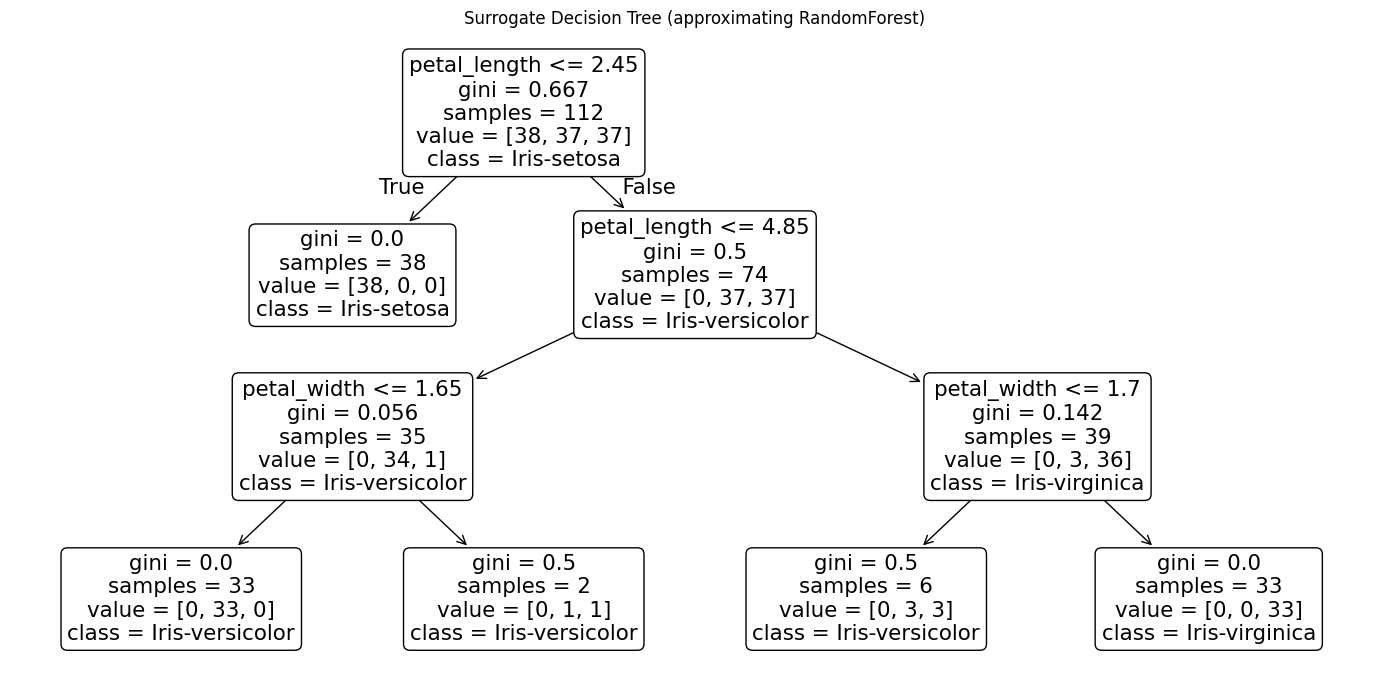

In [37]:
# --- Exercise 5 solution sketch: surrogate tree for a random forest ---
# Train RF (already trained above as 'rf'). Use RF predictions as labels for a surrogate tree.
rf_train_labels = rf.predict(X_train)
rf_test_labels  = rf.predict(X_test)

sur = DecisionTreeClassifier(max_depth=3, min_samples_leaf=2, random_state=RANDOM_STATE)
sur.fit(X_train, rf_train_labels)

sur_pred = sur.predict(X_test)
print("Surrogate vs RF agreement (accuracy):", accuracy_score(rf_test_labels, sur_pred))

plt.figure(figsize=(14, 7))
plot_tree(sur, feature_names=X.columns, class_names=sorted(y.unique()), filled=False, rounded=True)
plt.title("Surrogate Decision Tree (approximating RandomForest)")
plt.tight_layout()
plt.show()